In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import keras
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, image
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [5]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [6]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [7]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [8]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [9]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [10]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [11]:
import knifey

In [12]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [13]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


In [14]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

In [15]:
model = VGG16(include_top=True, weights='imagenet')

In [16]:
# from that we know input shape of the model
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [17]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range =180,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range=0.1,
                                  zoom_range=[0.9,1.5],
                                  horizontal_flip = True,
                                  vertical_flip= True,
                                  fill_mode = 'nearest')

In [18]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [19]:
if True:
    save_to_dir = None
else:
    save_to_dir = 'augmented_images'

In [31]:
batch_size = 10

In [21]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                   target_size= input_shape,
                                                   batch_size = batch_size,
                                                   shuffle=True,
                                                   save_to_dir=save_to_dir)

Found 4170 images belonging to 3 classes.


In [24]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                   target_size= input_shape,
                                                   batch_size = batch_size,
                                                   shuffle=False)

Found 530 images belonging to 3 classes.


In [32]:
steps_test = generator_test.n/batch_size
steps_test

53.0

In [33]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [35]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [36]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony']

In [39]:
num_classes = len(class_names)
num_classes

3

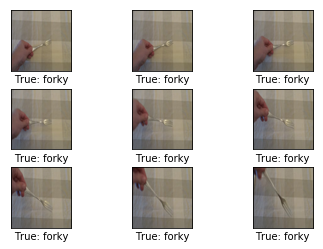

In [40]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [41]:
from sklearn.utils.class_weight import compute_class_weight

In [42]:
class_weight = compute_class_weight(class_weight='balanced',
                                   classes = np.unique(cls_train),
                                   y=cls_train)

In [43]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])